# **Introduction to PyTorch and a first example of a CNN overfitting an image**


Some introductory material in the Lab is taken from the excellent colab pages of Gaetan Bahl: http://gaetanbahl.engineer/teaching/ especially his Lab 1: https://colab.research.google.com/drive/1Xh9UsMQmhZ7RAYqmQFn4KtwPo1U877MB 

If you are unfamiliar with Python, his Lab 0 is an excellent resource: https://colab.research.google.com/drive/16XlCqmmUQvwBD3D5u0lOy1rUFfDDZdYi


The goal of this lab is to introduce the pytorch framework, and the very basic notions of a CNN: defining a network architecture, optimizer and a loss. We introduce a very simple example of a CNN that learns the identity function by overfitting to an image, and then show how variants of this can be used to learn the blur function. The goal of the exercise is to learn the basic structures of pytorch for setting up CNNs and the basic building blocks needed.

# **First Notions**

## What's a CNN?

Convolutional Neural Networks are a subclass of Neural Networks that use Convolutional layers. These layers are basically sliding filters and work quite well for vision and graphics tasks.


## What's a framework and why are we using one (PyTorch)?

A programming framework is a collection of functions and utilities that is ready to use. Modern Deep Learning frameworks contain everything that is needed (layers, optimizers, losses, gradient computation...) to create and use neural networks, and make that really easy.

PyTorch, originally created by Facebook, is one of the most used frameworks, especially among researchers. The other most used framework are Tensorflow (created by Google) and Keras (an abstraction layer for multiple frameworks, including Tensorflow). PyTorch has gained a lot of popularity since its 1.0 release in 2018.

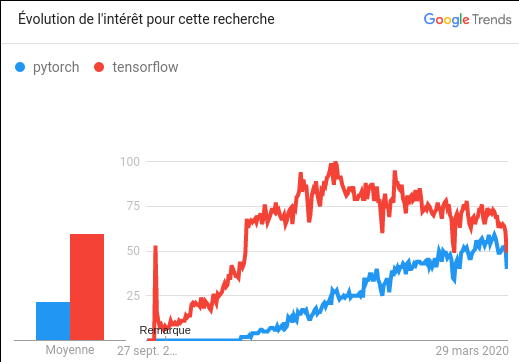

![alt text](https://miro.medium.com/max/1200/1*s_BwkYxpGv34vjOHi8tDzg.png)

## Why use Google Colab and GPUs?

Google Colab is a collaborative workspace based on Jupyter Notebook, that lets you use a Python environment on Google Cloud with GPUs, for FREE!

GPUs (Graphical Processing Units) are powerful chips that let you train and use neural networks much faster than CPUs. Having access to a GPU is very important for Deep Learning, as it can often make training more than 100x faster. It might not seem that huge at first, but state of the art neural nets can take days to train on common datasets, even with multiple powerful GPUs. On CPUs, it would take **years**.

Colab gives you access to a free Nvidia Tesla K80, P4, T4 or P100 GPU, which cost from 1000€ to 6000€ with 24GB, 8GB, 16GB or 16GB of VRAM, respectively.

![alt text](https://gitcdn.xyz/cdn/Tony607/blog_statics/b9259799b5bf99efdf761fed8827ff28638c8599/images/colab/pytorch-colab.png)

## /!\ IMPORTANT: Use a GPU Runtime

To use a GPU in Colab, go to Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU.

**Do this step before running the training part of the code below. It is best to use to a "standard environment" (CPU) while you are editing to avoid using your GPU time limit**. Switch to GPU when you start training, even though this means running all of the code you have written again.

# Checking that you have a GPU

Make sure you have are still in GPU Runtime mode. Before going any further, let's check that we do have a GPU and which model we actually got. For this, we will use the **nvidia-smi** tool, which let's you monitor GPU usage, VRAM usage, temperature and fan speed.

Colab let's you run bash commands using a "!". 




In [ ]:
!nvidia-smi

Sat Sep 24 17:34:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now switch back to the CPU environment Runtime -> Change Runtime Type -> None

You will switch back to a GPU once you are ready to train (see below).

## Importing libraries

For this lab, we only use a few PyTorch packages: "torch" and "torchvision".

"**torch**" contains the Deep Learning framework itself. We import this as th.

"**torchvision**" contains datasets, pre-trained models, and image manipulation functions.

We also use PIL for image manipulation, and use a few others (matplotlib and IPython) for display purposes.

In [ ]:
import torch as th
import torchvision

from PIL import Image
import PIL

# we need the display function from IPython for Jupyter Notebook/Colab
from IPython import display

# other utilities
from collections import OrderedDict
import matplotlib.pyplot as plt

# web utilities to get images from the web
import requests

import numpy as np

# Environment setup

Let's setup our environment. We define the device on which to run the experiment here. For now, stick to the CPU environment. When you will train, you need to start from here again, set to GPU environment, and uncomment the second line. You will need to run all the following code blocks again so they can be correctly initialized on the GPU.

In [ ]:
device = th.device("cpu")
#device = th.device("cuda:0") # Uncomment this to run on GPU

# Review of PyTorch Operations on Tensors

This question is a quick revision of pytorch operations on tensors. The syntax can be quite complex. **Please do not spend more than 10 min on this question; if you haven't finished, please move on to the next question after this time.**

Python is notoriously slow when dealing with large data. For this reason, numpy, as well, as most learning frameworks, work on arrays or tensors (N-dimensional matrix).

Manipulating the tensors insdead of directly iterating over the stored values requires a shift in perspective, especially for the programmer used to imperative langages (C/C++/...), but serves several purposes:

* the array operations are implemented with native languages, and as such are orders of magnitude faster
* the code is shorter and cleaner, close to the maths, which make it easier to develop and maintain
* array operations are usually straightforward to parallelize, and multiple CPU/GPU backends exists to run the code transparently on different hardware.

The most important operations with tensors are indexing and broadcasting. Internally, tensors hold data as a 1D vector, but python supports several tools to interpret them in arbitrary dimensions. By default, Pytorch uses the C convention for indexing, which means that the last dimension contains neighboring elements in memory. For instance, a 2D table will be accessed as a [row, collumn]. This is usually counter intruitive when we consider geometric data, since this implies indexing as a [y, x].

**Q1** Perform the set of exercise given below.

In [ ]:
a = th.arange(8)
print(a)

# transform 'a' into a 4x2 array
a = a.view(4,2)
print(a)
print(a.shape)

# print the element of 'a' at index (2,1)
print(a[2,1])

# IN THE NEXT EXERCISES I USED THAT THE FiRST LINE IS THE ONE WITH INDEX ZERO !!!

# print the first line of 'a'
print(a[0,:])

# print the first column of 'a'
print(a[:,0])

# swap the two columns of 'a' and store the result into 'a', in-place
a[:, [0, 1]] = a[:, [1, 0]]
print(a)

# use a mask (boolean list or tensor) to mask out the lines 1 and 3. print the result but do not modify 'a' 
mask = th.tensor([[True, True], 
                  [False, False],
                  [True, True],
                  [False, False]])
print(th.masked_fill(a, mask == True, value = -1))

# There are several ways to add/remove dimensions: 
# squeeze, unsqueeze, reshape, flatten, ..., 
# but most of these operations are also possible direclty with indexing:
# Use None as an index to add a (length 1) extra dimension:
print(a.shape[0])
a = a[None, :, :]
print(a.shape)

# Use the ellipsis operator (...) to add a dimension at the end of the tensor:
a = a[..., np.newaxis]
print(a.shape)

# Now dimensions 0 and 3 have size 1, so it is enough to index them with 0 to remove them:
a = a[0, :, :, 0]
print(a.shape)

# This can be an issue if we want to extract a single line but 
# without changing the number of dimensions:
#     print(a[0].shape) gives torch.Size([2]). 
# If we want torch.Size([1, 2]), we have to use a slice:
print(a[0:1].shape)

## Slicing:
# Slicing is used to extract parts of the array along one dimension, 
# following the syntax: a[start:end:step].
# Omiting one of the values fallback to the default behaviour: 
#   a[:], or a[::], is equivalent to a[0:a.shape[0]-1:1]
# Negative values are also supported and mean 'count from the last'

b = th.arange(12)
# Exercise: experiments with the different slices of b
print(b)
print(b[:-3])
print(b[3:7])

b = b.view(3, 4)
print(b)
print(b[:-1, 1:3])
print(b[1:3, :-1])

# Print the sum of adjacent values of b using two slices
# Note: the size of the resulting tensor is reduced by 1
b = th.arange(12)
sum_adj = th.zeros(11)
for i in range(11):
  sum_adj[i] = b[i-1] + b[i+1]
print(b)
print(sum_adj)


## A note on broadcasting:
# tensor operators might be supported even if the tensors 
# have different shapes, but only with specific rules:
# From https://pytorch.org/docs/stable/notes/broadcasting.html:
# - Each tensor has at least one dimension.
# - When iterating over the dimension sizes, starting at the trailing dimension, 
# the dimension sizes must either be equal, one of them is 1, or one of them does not exist.
#
# Broadcasting will essentially duplicate the tensor in the dimensions 
# that are 1 or missing, before applying the operation;
M = th.arange(9).reshape(3,3).to(float)
print(M)
v = th.tensor([.1,.2,.3])
print(v)

# Add v to each row of M
n = M.shape[0] 
m = M.shape[1]
sum1 = M.clone().detach()
for i in range(n):
  sum1[i,:] = M[i,:] + v
print(sum1)

# This will work too:
# sum1 = M + v
# print(sum1)

# Add v to each column of M (ie replicate v in three columns and add)
T = th.zeros(n, m)
for i in range(m):
  T[:,i] = v
sum2 = T + M
print(sum2)

# Broadcasting is very handy in many situations, but can also lead to complicated bugs. 
# It is critical to always track the shapes of the arrays in pytorch:
u = th.arange(3).unsqueeze(-1).float()
print(u)
# exercise: what is the shape of u+v and why? Why could it be misleadling?
print((u+v).shape) # torch.Size([3, 3])
print(u.shape)
print(v.shape)
# According to the documentation:
# If two tensors x, y are “broadcastable”, the resulting tensor size is calculated as follows:
# 1) If the number of dimensions of x and y are not equal, prepend 1 to the dimensions of the tensor with fewer dimensions to make them equal length.
# 2) Then, for each dimension size, the resulting dimension size is the max of the sizes of x and y along that dimension.
# Because of that, just looking at the shapes of u and v we would think that the shape of u+v would be [3,1]
# The shape of v is actually [1,3], but for it to show as such we would have to use a slice.

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]])
torch.Size([4, 2])
tensor(5)
tensor([0, 1])
tensor([0, 2, 4, 6])
tensor([[1, 0],
        [3, 2],
        [5, 4],
        [7, 6]])
tensor([[-1, -1],
        [ 3,  2],
        [-1, -1],
        [ 7,  6]])
4
torch.Size([1, 4, 2])
torch.Size([1, 4, 2, 1])
torch.Size([4, 2])
torch.Size([1, 2])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
tensor([3, 4, 5, 6])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
tensor([[1, 2],
        [5, 6]])
tensor([[ 4,  5,  6],
        [ 8,  9, 10]])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
tensor([12.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]], dtype=torch.float64)
tensor([0.1000, 0.2000, 0.3000])
tensor([[0.1000, 1.2000, 2.3000],
        [3.1000, 4.2000, 5.3000],
        [6.1000, 7.2000, 8.3000

# Setting up a basic network

All networks created with torch.nn are subclasses of nn.Module.

To create our network, we need to define two methods: the init method ("\_\_init\_\_") and the **forward** propagation method.



*   In the "**init**" function, we define the **parts** (layers) of the network we are going to use and store them as attributes 
*   In the "**forward**" function, we define the **order** of the layers by applying them to an input (define-by-run)





Let's begin with a simple network. The code below defines a class that implements nn.Module. 

We start with a very simple architecture. 

**Q2** **Fill in the code below** to implement a network parameterized by numLayers layers. Each layer contains convolutions of kernel size 3 followed by Relu activations, and should have width numFeatures. **Add** a final convolution to control the output. Set the padding appropriately.

Use the pytorch documentation to find the definitions for Conv2d and ReLU:  https://pytorch.org/docs/stable/nn.html


In [ ]:
from ast import increment_lineno
class Net(th.nn.Module):
    def __init__(self, numLayers, inChannels, outChannels, numFeatures):
        super(Net, self).__init__()
        
        layers = OrderedDict()
        # Add a convolution layer using 3x3 convolutions, with appropriate padding
        layers["inConv"] = th.nn.Conv2d(inChannels, numFeatures, kernel_size=3, stride=1, padding=1)
        # Add a ReLU layer
        layers["inRelu"] = th.nn.ReLU()
        
        # add extra layers to have numLayers Convolutions followed by ReLUs
        for i in range(numLayers):
          layers[f'conv{i}'] = th.nn.Conv2d(numFeatures, numFeatures, kernel_size=3, stride=1, padding=1)
          layers[f'relu{i}'] = th.nn.ReLU()
        # add output convolution layer
        layers["outConv"] = th.nn.Conv2d(numFeatures, outChannels, kernel_size=3, stride=1, padding=1)

        self.net = th.nn.Sequential(layers)
    
    def forward(self, x):
        return self.net(x)

To check if your code runs correctly, Initialize an instance of the class, as shown below (see next code block).
You should get the following output:

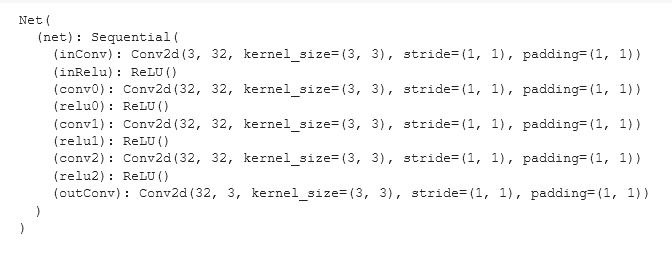




If you get different output, check the structure of the network to make sure you have the correct network definition.



In [ ]:
numFeatures = 32
numLayers = 3
inChannels = 3 # Number of channels of the input
outChannels = 3 # Number of channels of the output

model = Net(numLayers,inChannels, outChannels, numFeatures)
#Put the model on the right device
model.to(device)

Net(
  (net): Sequential(
    (inConv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (inRelu): ReLU()
    (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (outConv): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

# Defining an Optimizer and a Loss

You have now defined your first CNN, congratulations !

To achieve our task, we need also need:

1. An optimizer
1. A loss function
1. A way to feed data to the network

Our optimizer will be Stochastic Gradient Descent, provided natively in pytorch. We give a learning rate of 0.01 and momentum of 0.9, which are reasonable default values:

Use the pytorch documentation to find the definitions for optimizers https://pytorch.org/docs/stable/optim.html and losses: https://pytorch.org/docs/stable/nn.html

We will need to get the parameters from the model (network) you have defined.

**Q3** Complete the code below for optimizer and loss

In [ ]:
# Use torch SGD with learning rate 0.01 and momentum 0.9 
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

To start, we will use a standard L1 loss:

In [ ]:
# Use torch L1Loss 
loss_func = th.nn.L1Loss()

As we saw in class, neural networks are a universal function approximator. We will start with the simplest possible function, i.e., the identity. In other words, for this very simple example we just overfit the network to output a single image. 

We will feed the image as input and as GT. Here we will not use a data loader, this is left for later. In this exercise we will just use images downloaded directly from the web.

First download the image "koala.jpg" from http://www-sop.inria.fr/members/George.Drettakis/teaching/ENS_Lyon/TP1/koala.jpg.
We will access the file directly from colab.

In [ ]:
url = "http://www-sop.inria.fr/members/George.Drettakis/teaching/ENS_Lyon/TP1/koala.jpg"
image = Image.open(requests.get(url, stream=True).raw)

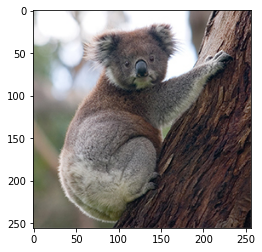

In [ ]:
plt.imshow(image)

# Convert the PIL image to a tensor, we unsqueeze to add a batch dimension
image_tensor = torchvision.transforms.ToTensor()(image).unsqueeze(0)

# We center the image between -1 and 1

image_tensor = 2*image_tensor - 1

# Put the image on the right device
image_tensor = image_tensor.to(device)
# Here we say that our ground truth is that image
gt = image_tensor

Next we define the function to run the network, for numIters iterations. 

**Q3 a** Complete the code for out and loss

In [ ]:
def runNet(numIters):
    numIt = numIters
    # plot data to display intermediate results 
    x = []
    y = []
    fig = plt.figure(figsize=(10, 5))
    implt = fig.add_subplot(1,2,1)
    lossplt = fig.add_subplot(1,2,2)

    for it in range(numIt):
    
        # We do the forward pass
        # call the model with image_tensor (the input); returns the output tensor
        out = model(image_tensor)
        
        # We compute the loss
        # set the loss with the output tensor and ground truth as parameters 
        loss = loss_func(out, gt)
    
        # We reset the gradients to zero to avoid them accumulating
        optimizer.zero_grad()

        # We compute the backward pass
        loss.backward()
    
        # Print the loss and the output every 10 iterations
        if it%10 == 0:
        
            output_image = torchvision.transforms.ToPILImage()(th.clamp(0.5+out[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
 
            x.append(it)
            y.append(loss.item())
        
            implt.imshow(output_image)
            implt.title.set_text("it:"+str(it)+" loss:"+str(loss.item()))
            lossplt.plot(x,y)
            lossplt.title.set_text("Loss")
        
            display.display(fig)
            display.clear_output(wait=True)
    
    
        # Based on the computed gradient we can execute a step of the optimizer.
        # That means modifying the weights of the model based on the learning rate and momentum
        optimizer.step()
        

Now you can run the network for 100 iterations (see code block below). Your output should look like this:  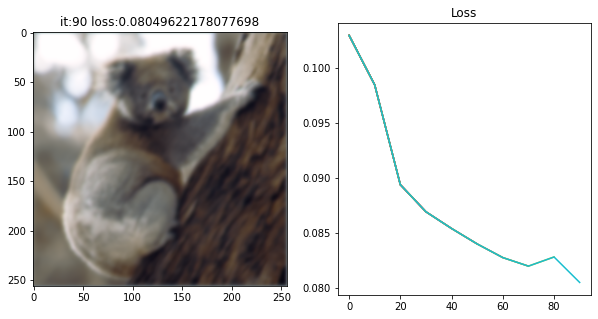

You need to re-initialize the optimizer (ie run the command you used above) before each run.

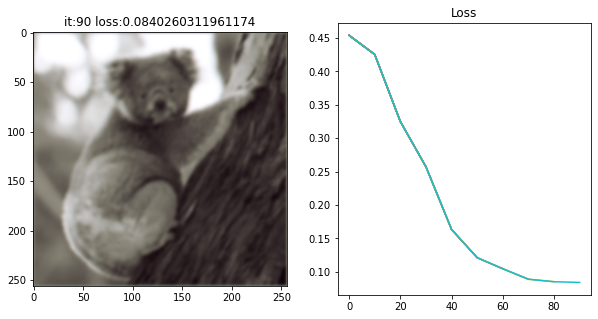

In [ ]:
# reset optimizer
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
runNet(100)

If your output is similar, you are now ready to train for 800 iterations on the GPU. Switch your environment to the GPU (see Environment Setup) and then re-run all the code blocks from "Importing Libraries" and after that one. Training should take a few minutes.

**Q4:** Fix the optimizer and run the network; While the network is training, what do you observe about the process ?

Your answer:
With every 10 iterations our image is starting to look more like the ground truth and the value of our loss function decreasing and approaching zero. 

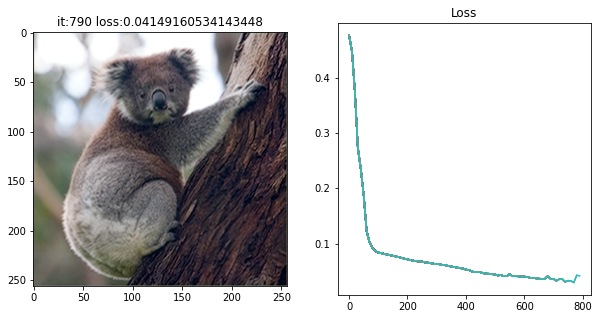

In [ ]:
# reset optimizer
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
runNet(800)


We have now seen that it is possible to learn the identity function. Our next task will be to see if the network can learn the blur function.  

**Q5:** First train on a single image, using a blurrred version as ground truth, and then see if the trained network is sufficiently general to blur a different image.

Start by copying the same network as above. You will modify the network to do several tests below.

In [ ]:
class NetBlur(th.nn.Module):
    def __init__(self, numLayers, inChannels, outChannels, numFeatures):
      # replicate previous network
      super(NetBlur, self).__init__()
        
      layers = OrderedDict()
      # Add a convolution layer using 3x3 convolutions, with appropriate padding
      layers["inConv"] = th.nn.Conv2d(inChannels, numFeatures, kernel_size=3, stride=1, padding=1)
      # Add a ReLU layer
      layers["inRelu"] = th.nn.ReLU()
        
      # add extra layers to have numLayers Convolutions followed by ReLUs
      for i in range(numLayers):
        layers[f'conv{i}'] = th.nn.Conv2d(numFeatures, numFeatures, kernel_size=3, stride=1, padding=1)
        layers[f'relu{i}'] = th.nn.ReLU()
      # add output convolution layer
      layers["outConv"] = th.nn.Conv2d(numFeatures, outChannels, kernel_size=3, stride=1, padding=1)

      self.net = th.nn.Sequential(layers)

    def forward(self, x):
        return self.net(x)

Use the L2 loss instead (Mean Square Error in torch).

In [ ]:
numLayers = 2
numFeatures = 32
# Use torch MSE loss
loss_func = th.nn.MSELoss()

# set the model to NetBlur; runNet will now use this !

model = NetBlur(numLayers,inChannels, outChannels, numFeatures)

# Put the model on the right device
model.to(device)


NetBlur(
  (net): Sequential(
    (inConv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (inRelu): ReLU()
    (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (outConv): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

We have an original image "birds.png" and its blurred version "birds_blur_3x3.png". We download them and set the ground truth the the blurred version.

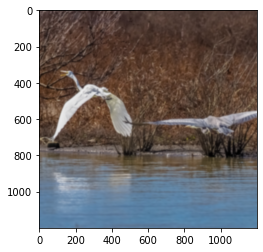

In [ ]:
url = "http://www-sop.inria.fr/members/George.Drettakis/teaching/ENS_Lyon/TP1/birds_blur_3x3.png"
blurBirdImage = Image.open(requests.get(url, stream=True).raw)

plt.imshow(blurBirdImage)
# Convert the PIL image to a tensor, we unsqueeze to add a batch dimension
image_tensor = torchvision.transforms.ToTensor()(blurBirdImage).unsqueeze(0)
# We center the image between -1 and 1
image_tensor = 2*image_tensor - 1
# Put the image on the right device
image_tensor = image_tensor.to(device)
# Here we say that our ground truth is that image
gt = image_tensor


We then download the original image which we will use as input.


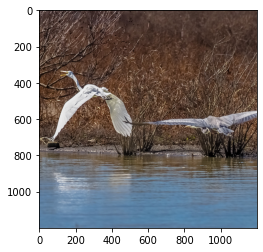

In [ ]:
url = "http://www-sop.inria.fr/members/George.Drettakis/teaching/ENS_Lyon/TP1/birds.png"
birdsImage = Image.open(requests.get(url, stream=True).raw)

plt.imshow(birdsImage)
# Convert the PIL image to a tensor, we unsqueeze to add a batch dimension
image_tensor = torchvision.transforms.ToTensor()(birdsImage).unsqueeze(0)
# We center the image between -1 and 1
image_tensor = 2*image_tensor - 1
# Put the image on the right device
image_tensor = image_tensor.to(device)

image2 = torchvision.transforms.ToPILImage()(th.clamp(0.5+ image_tensor[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
plt.imshow(image2)

We can now run the network for 250 iterations. 

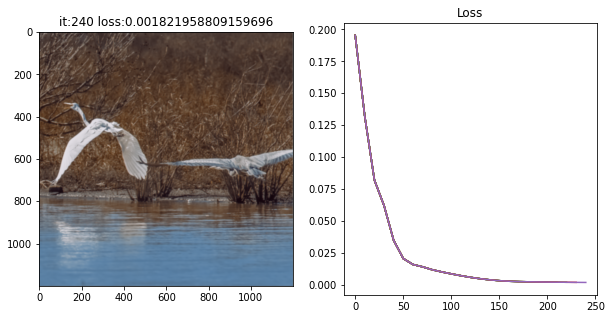

In [ ]:
# reset optimizer
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
runNet(250)

We provide a utility to zoom into the images and compare the result of the network ("Network Output") with the input.


In [ ]:
# utility function to show input image and network output zoomed in

def showZoom(image1, image1Label):
    # Show zoomed images to see effect

    x1=[]
    y1=[]
    res_fig = plt.figure(figsize=(10, 5))
    res_plt = res_fig.add_subplot(1,2,1)
    cnn_plt = res_fig.add_subplot(1,2,2)

    crop = image1.crop((512,256,1024,768))
    res_plt.imshow(crop)
    res_plt.title.set_text(image1Label)

    image1_tensor = torchvision.transforms.ToTensor()(image1).unsqueeze(0)
    image1_tensor = image1_tensor.to(device)

    out = model(image1_tensor)
    output_image = torchvision.transforms.ToPILImage()(th.clamp(out[0].cpu(), min=0.0, max=1.0)) # we do out[0] to remove the batch dimension

    crop1 = output_image.crop((512,256,1024,768))
    cnn_plt.imshow(crop1)
    cnn_plt.plot(x1,y1)
    cnn_plt.title.set_text("Network Output")
        
    display.display(res_fig)
    display.clear_output(wait=True)

You can now run this with the input image:

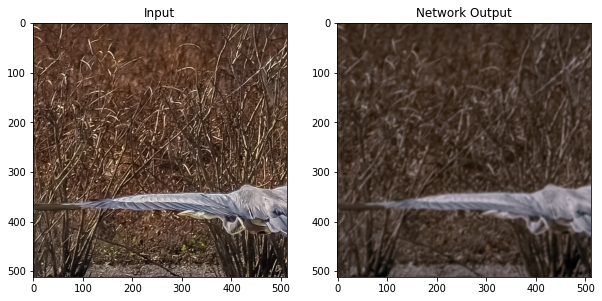

In [ ]:
showZoom(birdsImage, "Input")

**Q6:** What do you observe ? Did the network learn the blur function ?

Your answer here:
No, the network did not learn the blur function. The colors of the picture are not reproduces accuratelly.

If you are not satisfied with the result, try removing the ReLU activations from the network. Please do this with a copy of the network that you define below.



In [ ]:
class NetBlur2(th.nn.Module):
    def __init__(self, numLayers, inChannels, outChannels, numFeatures):
        # define the same network, but without the ReLU activations
        super(NetBlur2, self).__init__()
        
        layers = OrderedDict()
        # Add a convolution layer using 3x3 convolutions, with appropriate padding
        layers["inConv"] = th.nn.Conv2d(inChannels, numFeatures, kernel_size=3, stride=1, padding=1)
        
        # add extra layers to have numLayers Convolutions 
        for i in range(numLayers):
          layers[f'conv{i}'] = th.nn.Conv2d(numFeatures, numFeatures, kernel_size=3, stride=1, padding=1)
        # add output convolution layer
        layers["outConv"] = th.nn.Conv2d(numFeatures, outChannels, kernel_size=3, stride=1, padding=1)

        self.net = th.nn.Sequential(layers)
    def forward(self, x):
        return self.net(x)

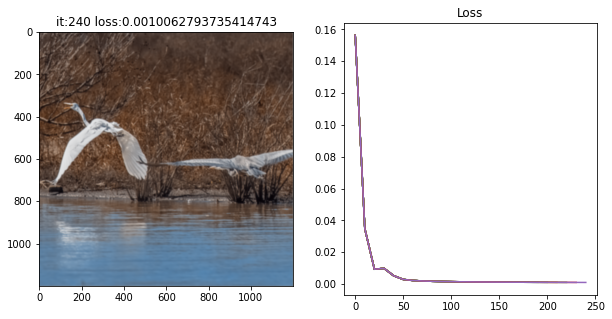

In [ ]:
# set the model to NetBlur2; runNet will not use this !

model = NetBlur2(numLayers,inChannels, outChannels, numFeatures)

#Put the model on the right device
model.to(device)

# reset optimizer
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
runNet(250)

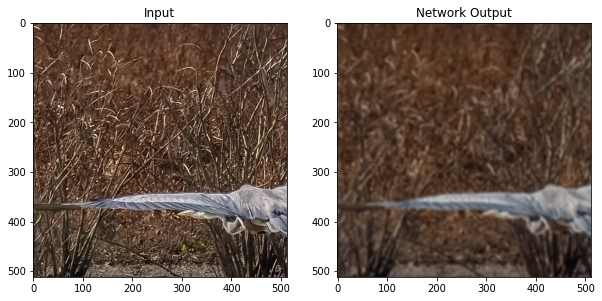

In [ ]:
showZoom(birdsImage, "Input")

**Q7:** What do you observe ? How do you explain this improvement ?

Your answer here:
Unlike the previous result, we now have a blurred image whose colors match the original colors. In RGB, blue has the smallest values. Using ReLU turns all negativ values to zero. That's why we have much less blue in the first picture than in the second one.  

Now let's see if the network generalizes to another image. First load the "duck" image  (http://www-sop.inria.fr/members/George.Drettakis/teaching/ENS_Lyon/TP1/duck.png) and then use the showZoom function to see the result. 

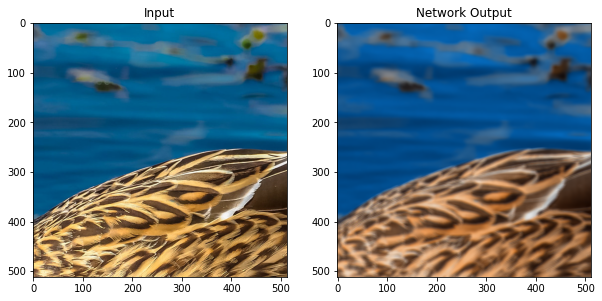

In [ ]:
url = "http://www-sop.inria.fr/members/George.Drettakis/teaching/ENS_Lyon/TP1/duck.png"
duckImage = Image.open(requests.get(url, stream=True).raw)

showZoom(duckImage, "Input")

**Q8:** What do you observe ?

    Your answer here: The network is able to learn the blur function when used without the ReLU activation function, 
    but potentially adds more blue to it. 

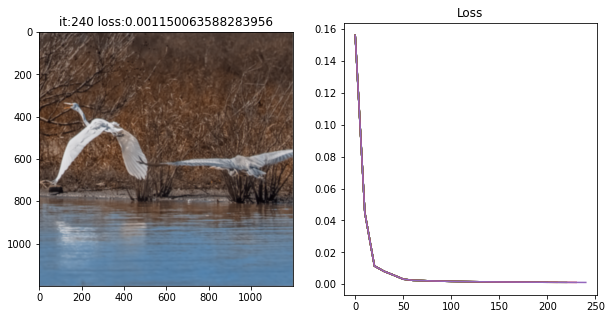

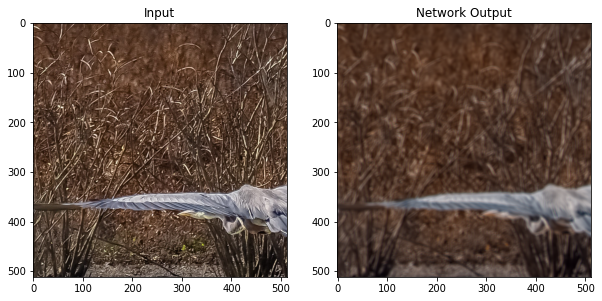

In [ ]:
# Experiment with the number of layers; Try using 2 layers

numLayers = 2

# set the model to NetBlur2
model = NetBlur2(numLayers,inChannels, outChannels, numFeatures)

#Put the model on the right device
model.to(device)

# reset optimizer
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

runNet(250)

showZoom(birdsImage, "Input")

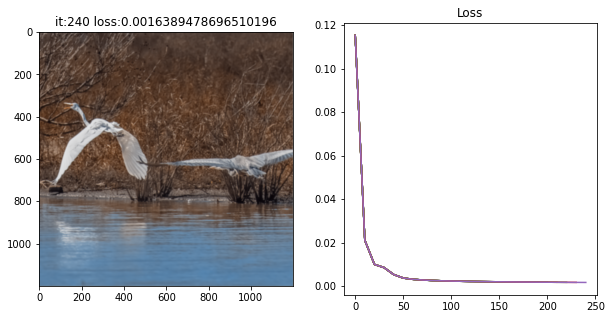

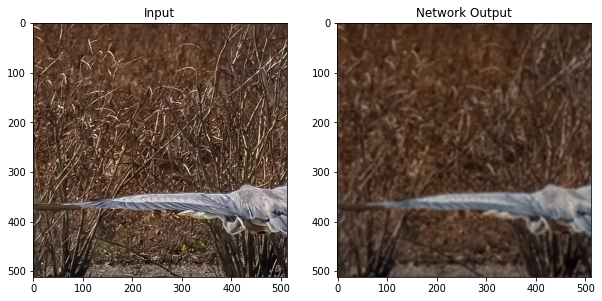

In [ ]:
# Experiment with the number of layers; Try using 1 layer

numLayers = 1

# set the model to NetBlur2
model = NetBlur2(numLayers,inChannels, outChannels, numFeatures)

#Put the model on the right device
model.to(device)

# reset optimizer
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

runNet(250)

showZoom(birdsImage, "Input")

**Q9**: what is the effect of using a 2 or even 1 layer ?
    Your Answer: I seems like using 2 or even 1 layer don't change the result much. I think that it is because blur is an easy function for the network to learn.

One way to improve the result is to train the network on both the duck and the bird images. 


**Q10.** First use the PIL blur function to create the blurred images (use a 5x5 Gaussian blur
https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html) and create an image_tensor2
and a gt2 pair.

Then you will need to create a new runNet2 function that will alternate training between the
bird and duck original/blur pairs. You can use the same NetBlur model for this step.



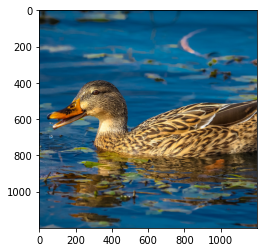

In [ ]:
# Convert the PIL image to a tensor, we unsqueeze to add a batch dimension
image_tensor2 = torchvision.transforms.ToTensor()(duckImage).unsqueeze(0)
# We center the image between -1 and 1
image_tensor2 = 2*image_tensor2 - 1
# Put the image on the right device
image_tensor2 = image_tensor2.to(device)

# check by visualizing
image_duck2 = torchvision.transforms.ToPILImage()(th.clamp(0.5+ image_tensor2[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
plt.imshow(image_duck2)

# use PIL filtering to create a new gt2
# dont forget to create the torch tensor and to put on the right device
image_duck_blured = image_duck2.filter(PIL.ImageFilter.GaussianBlur(radius = 5))
gt2 = torchvision.transforms.ToTensor()(image_duck_blured).unsqueeze(0)
gt2 = 2*gt2 - 1
gt2 = gt2.to(device)

# modify the original runNet function to alternate training between bird and duck images
def runNet2(numIters):
    numIt = numIters
    # plot data to display intermediate results 
    x = []
    y = []
    fig = plt.figure(figsize=(25, 5))
    implt_n1 = fig.add_subplot(1,4,1)
    implt_n2 = fig.add_subplot(1,4,3)
    lossplt_n1 = fig.add_subplot(1,4,2)
    lossplt_n2 = fig.add_subplot(1,4,4)

    for it in range(numIt):
      # for bird
      if it % 2 == 0:
        out_1 = model(image_tensor)
        loss = loss_func(out_1, gt)
        optimizer.zero_grad()
        loss.backward()

        if it % 25 == 0:
          output1_image = torchvision.transforms.ToPILImage()(th.clamp(0.5+out_1[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
          
          x.append(it)
          y.append(loss.item())
            
          implt_n1.imshow(output1_image)
      
          implt_n1.title.set_text("step:"+str(it)+"/" +" loss:"+str(loss.item()))
        
          lossplt_n1.plot(x,y)
          lossplt_n1.title.set_text("Loss 1")
            
          display.display(fig)
          display.clear_output(wait=True)
            
          plt.show()
      # for duck
      else: 
        out_2 = model(image_tensor2)
        loss = loss_func(out_2, gt2)
        optimizer.zero_grad()
        loss.backward()

        if it % 25 == 0:
          output2_image = torchvision.transforms.ToPILImage()(th.clamp(0.5+out_2[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
          
          x.append(it)
          y.append(loss.item())
            
          implt_n2.imshow(output2_image)
      
          implt_n2.title.set_text("step:"+str(it)+"/" +" loss:"+str(loss.item()))
        
          lossplt_n2.plot(x,y)
          lossplt_n2.title.set_text("Loss 2")
            
          display.display(fig)
          display.clear_output(wait=True)
            
          plt.show()
      
      optimizer.step()

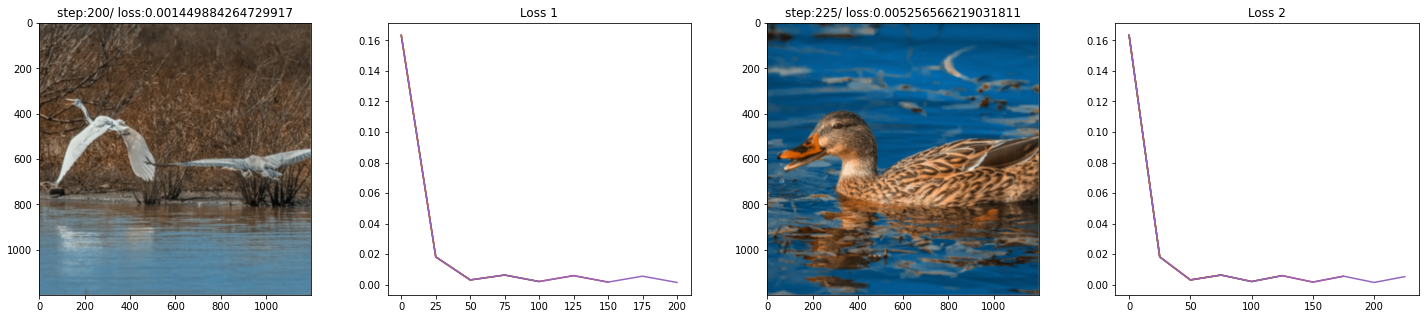

In [ ]:
numFeatures = 32
numLayers = 3
inChannels = 3 
outChannels = 3 

model = NetBlur2(numLayers,inChannels, outChannels, numFeatures)
model.to(device)    
    
# reset optimizer
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

runNet2(250)

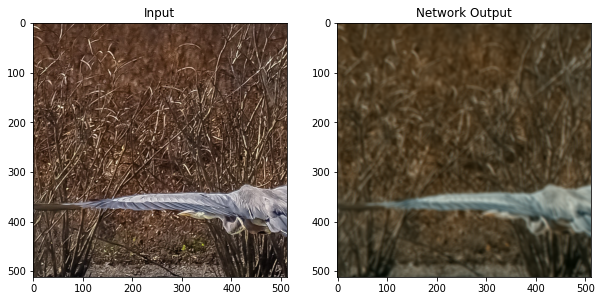

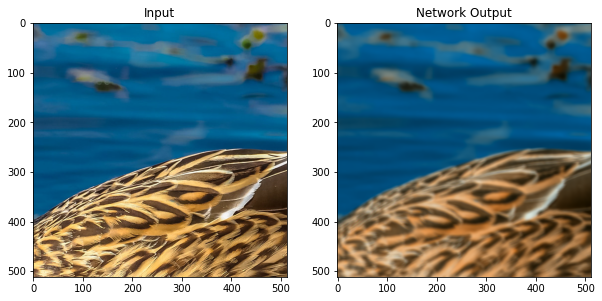

In [ ]:
showZoom(birdsImage, "Input")
showZoom(duckImage, "Input")

**Q11**: What is the effect of the alternate training approach ?
    Your Answer: I think that the alternate traingin is beter because we are training on more than one picture which have different colors in them. The result should be more convenient in terms of representing the colors faithfully. In this particular case, we got beter results for the image of duck.

Bonus questions:

Download another image from the internet and see whether the previous network generalizes as well or whether it still has artifacts. Discuss.

You can experiment with other aspects of the network (number of features), as well as the loss or the optimizer to see the effect on the result and on the generalization. 

If you do these tests, please add them as code blocks and corresponding text explanations below.